# Import libraries and dataset

In [ ]:
!pip install -q datasets
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q albumentations
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 38.3/38.3 MB 133.7 MB/s eta 0:00:01

In [ ]:
!git clone https://github.com/pedropro/TACO
%cd TACO

In [ ]:
!pip install -r requirements.txt

In [ ]:
## ---- CONTROLLA ALLA FINE SE CI SERVE TUTTO
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from datasets import load_dataset
# per fare i poligoni. ci serve ancora?
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab
import requests
import torch
from urllib.request import urlopen
import albumentations as A
%matplotlib inline
import json
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
import pickle

# # Load
with open('dataset_taco.pkl', 'rb') as f:
    dataset_taco = pickle.load(f)

In [ ]:
dataset_taco1 = load_dataset("RandyHuynh5815/TACO-Reformatted-Full")

**TACOset** ha il formato dataset. Da usare quando si vuole visualizzare un'immagine

e.g. img = TACOset[12]['image']

In [8]:
TACOset = dataset_taco1['train'].select(range(300))

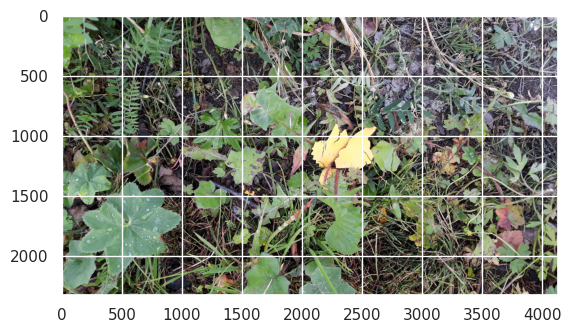

In [9]:
plt.imshow(TACOset[230]['image'])

In [10]:
dataset_taco['images'][230]

{'id': 230,
 'width': 2322,
 'height': 4128,
 'file_name': 'batch_11/000029.jpg',
 'license': 'ODBL (c) OpenLitterMap & Contributors',
 'flickr_url': 'https://olm-s3.s3.eu-west-1.amazonaws.com/2019/07/25/Z2uuIQ0z0b5UWEWEJDxAuKxlovLZIkZZAfmJrGPs.jpeg',
 'flickr_640_url': None,
 'coco_url': None,
 'date_captured': None}

In [10]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [11]:
coco = COCO(anns_file_path)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


# Preprocessing

## Label 60

In [12]:
for c in dataset_taco['categories']:
  if c['id'] == 0:
    c['id'] = 60

for a in dataset_taco['annotations']:
  if a['category_id'] == 0:
    a['category_id'] = 60


dataset_taco['categories'].append({'supercategory': 'Background', 'id': 0, 'name': 'Background'})

## Color palette

In [13]:
def color_palette():
    """Color palette that maps each class to RGB values.

    This one is actually taken from ADE20k.
    """
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

palette = color_palette()

## Mask generation

In [14]:
import torch

# Assicurati che la GPU sia disponibile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

coco = COCO(anns_file_path)
indexes_to_remove = []

TACOset2 = []

for ind, img in enumerate(dataset_taco['images'][:300]):

  if img['id'] == 93:
    indexes_to_remove.append(ind)
    continue

  image = {}
  image['id'] = img['id']

  image['image'] = TACOset[img['id']]['image'] # rendi lista

  annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
  anns_sel = coco.loadAnns(annIds)

  binary_mask = []
  categories = []

  for i, ann in enumerate(anns_sel):
    binary_mask.append(coco.annToMask(ann))
    categories.append(ann['category_id'])

  image['binary_masks'] = torch.tensor(np.array(binary_mask)).to(device)
  image['label_classes'] = torch.tensor(np.array(categories)).to(device)

  TACOset2.append(image)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


## Data visualization


In [17]:
TACOset2[0]

{'id': 0,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1537x2049>,
 'binary_masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.uint8),
 'label_classes': tensor([6], device='cuda:0')}

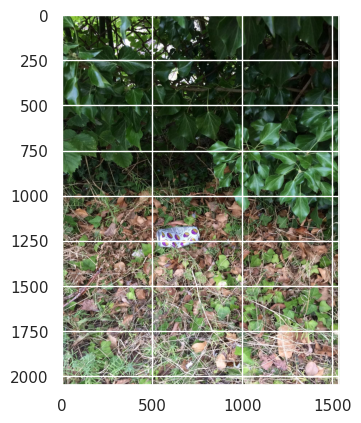

In [25]:
id = 18
img = TACOset2[id]['image']
plt.imshow(img)

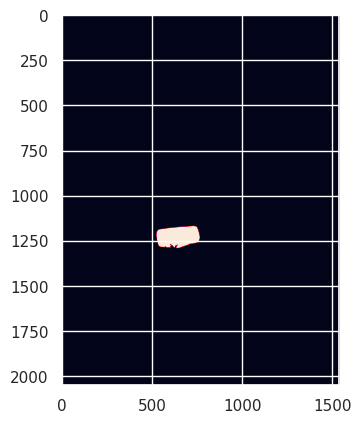

In [26]:
img = TACOset2[id]['binary_masks'][0].cpu()
plt.imshow(img)

## Train and test split

In [15]:
from sklearn.model_selection import train_test_split
import random


# # shuffle + split dataset
TACOset_train, TACOset_test = train_test_split(TACOset2, test_size=0.25, random_state = 2026)

In [21]:
# Obtain Exif orientation tag code
# for orientation in ExifTags.TAGS.keys():
#     if ExifTags.TAGS[orientation] == 'Orientation':
#         break
import numpy as np
from torch.utils.data import Dataset
import requests
from PIL import Image
import matplotlib.pyplot as plt

import urllib.request
from urllib.request import urlopen


class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, dataset, transform):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

      for orientation in ExifTags.TAGS.keys():
        if ExifTags.TAGS[orientation] == 'Orientation':
            break

      I = self.dataset[idx]['image']

      # Load and process image metadata
      if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

      original_image = np.array(I)
      original_binary_masks = np.array(self.dataset[idx]['binary_masks'].cpu())

      transformed = self.transform(image=original_image, mask=original_binary_masks.transpose(1,2,0))

      image, binary_masks = transformed['image'], transformed['mask']

      original_id = self.dataset[idx]['id']
      label_classes = self.dataset[idx]['label_classes'].cpu()

      # convert to C, H, W
      #image = image.transpose(2,0,1)
      binary_masks = binary_masks.transpose(2,0,1)

      return image, binary_masks, original_image, original_binary_masks, label_classes, original_id

In [22]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

train_transform = A.Compose([
    A.LongestMaxSize(max_size=1200),
    A.Resize(width=256, height=256),
    A.HorizontalFlip(p=0.5)],
    # A.Normalize(mean=ADE_MEAN, std=ADE_STD)],
    is_check_shapes = False
)

test_transform = A.Compose([
    A.Resize(width=256, height=256),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD)],
    is_check_shapes = False

)

train_dataset = ImageSegmentationDataset(TACOset_train, transform=train_transform)
test_dataset = ImageSegmentationDataset(TACOset_test, transform=test_transform)

In [23]:
image, binary_masks, original_image, original_binary_masks, label_classes, original_id = train_dataset[45]

In [47]:
original_binary_masks

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

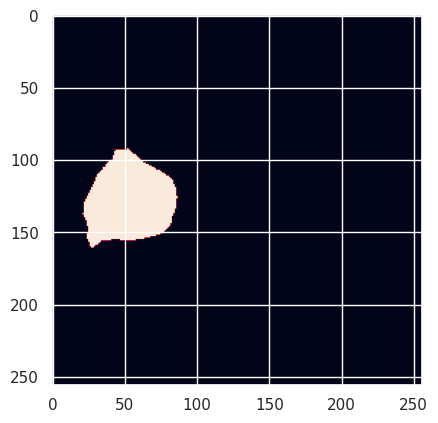

In [31]:
plt.imshow(binary_masks[1])

In [33]:
id2label2 = {}
for k in dataset_taco['categories']:
  id2label2[k['id']] = k['id']

In [112]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    inputs = list(zip(*batch))
    # images = inputs[0]
    # segmentation_maps = inputs[1]
    # this function pads the inputs to the same size,
    # and creates a pixel mask
    # actually padding isn't required here since we are cropping
    '''
    batch = preprocessor(
        images,
        segmentation_maps=segmentation_maps,
        return_tensors="pt",
    )
    '''
    return {
        "pixel_values": torch.tensor(inputs[0]),
        "mask_labels": list(inputs[1]),
        "original_image": inputs[2],
        "original_masks": inputs[3],
        "class_labels": list(inputs[4])
    }

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [113]:
import torch
i = 0
# batch = next(next(next(iter(train_dataloader))))
for batch in train_dataloader:
  for k,v in batch.items():
    if isinstance(v, torch.Tensor):
      print(k,v.shape)
    else:
      print(k,v[0].shape)
  break

pixel_values torch.Size([2, 256, 256, 3])
mask_labels (5, 256, 256)
original_image (4000, 1824, 3)
original_masks (5, 4000, 1824)
class_labels torch.Size([5])


In [114]:
batch["pixel_values"].shape

torch.Size([2, 256, 256, 3])

# Train and test

In [62]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-ade",
                                                          id2label=id2label2,
                                                          ignore_mismatched_sizes=True).to(device)

config.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/412M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of MaskFormerForInstanceSegmentation were not initialized from the model checkpoint at facebook/maskformer-swin-base-ade and are newly initialized because the shapes did not match:
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([62, 256]) in the model instantiated
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([62]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([62]) in the model instantiated
You should probably TRAIN this model on a d

In [115]:
outputs = model(batch["pixel_values"],
                class_labels=batch["class_labels"],
                mask_labels=batch["mask_labels"])
outputs.to(device)

ValueError: Make sure that the channel dimension of the pixel values match with the one set in the configuration.